## READ ME

This is the notebook to compare the Gibbs Free Energy Change along the glycolysis pathway. The Free Energy Changes are calculated from both thermodynamic (eQuilibrator) and kinetic (rate constants in WCM).

**Conda Environment**  
The best implemetation is to create a new conda env using the `eQuialibrator.yml` file. eQuilibrator API is compatible with only python version >= 3.8. 

**Input File**  
To run this code, please input the pathways of *kinetic_params.xlsx* that used in the simulation and concentration.csv. The format of concentration.csv is shown in file './avg_concs_10thSeptember_1200_1800.csv'.

**Output**  
This Notebook will plot Standard Gibbs Energy, Gibbs Energy Change and Cumulative Gibbs Energy Change in a progressive way. The figures will be stored in a separate foleder created based on the date of simulation. Flux plot is not included yet.



In [1]:
import numpy as np
import pandas as pd
import os

#FBA Model
import cobra
# import cobra.test
from cobra.flux_analysis import flux_variability_analysis

#equilibrator stuff
from equilibrator_api import ComponentContribution, Q_

# plot_Gibbs.py has three functions to plot deltaG0, deltaG and cumulative deltaG
import plot_Gibbs
%matplotlib inline

eQuilibrator Property Set up  
**First Run will download eQuilibrator data from Zenodo**

In [2]:
plot_ub = True
plot_FBA_rev = True
plot_keq_equilibrator = True

T = 303.0
RT = (8.314*1.0E-3)*T
pH = 7.0
pMG = 2.6

cc = ComponentContribution() # eQuialibrator object
cc.p_h = Q_(pH)
cc.p_mg = Q_(pMG)
cc.ionic_strength = Q_("0.1M")
cc.temperature = Q_("{:.2f}K".format(T))

Pathways of input files

In [15]:
simulationDate = 'April2025'

N_reps = 50

time_period = 'entire'

kinetic_params_path = '/data/enguang/CMEODE/input_data/kinetic_params_4DWCM.xlsx'

# this path is not a variable
initial_concentrations_path = '/data/enguang/CMEODE/input_data/initial_concentrations.xlsx'

# Concentration File exported 
conc_file = '/data/enguang/4DWCM/April2025/output_concs/avg_concs_April2025_60_5640.csv'

conc_df = pd.read_csv(conc_file,delimiter=',')

In [16]:
figs_subfoler = f'./{simulationDate}'

if not os.path.exists(figs_subfoler):
    os.makedirs(figs_subfoler)


### Cunstom Functions

#### Parse Reactions and Reaction Parameters

In [17]:
def getKcats(kinetic_params,rxn_name):
    
    tmpdf = kinetic_params[kinetic_params['Reaction Name']==rxn_name]
    kf = float(tmpdf[tmpdf['Parameter Type']=='Substrate Catalytic Rate Constant']['Value'].values[0])
    kr = float(tmpdf[tmpdf['Parameter Type']=='Product Catalytic Rate Constant']['Value'].values[0])
    
    return kf, kr

def getKMs(kinetic_params,rxn_name,species_list):
    
    KMs = {}
    for spc in species_list:
        tmpdf = kinetic_params[kinetic_params['Reaction Name']==rxn_name]
        tmpdf2 = tmpdf[tmpdf['Parameter Type']=='Michaelis Menten Constant']
        KMs[spc] = float(tmpdf2[tmpdf2['Related Species']=='M_'+spc]['Value'].values[0])
        
    return KMs

#Get Keq Values
def getKcatsKeq(kinetic_params,r):
    """
    Input:
        kinetic_params: df of reaction r read from Excel file
        r: reaction handle in cobrapy
    Return: kf, kr, and kinetic calculated Keq and reaction reversibility 
    """
    # r is the reaction in SBML file read by cobra
    ignore_spcs = ['h_c','h2o_c','o2_c']
    subs = []
    prods = []
    nu_subs = {}
    nu_prods = {}
    
    for spc in r.reactants:
        if spc.id not in ignore_spcs:
            nu_subs[spc.id] = int(np.abs(r.get_coefficient(spc.id)))
            subs.append(spc.id)
    for spc in r.products:
        if spc.id not in ignore_spcs:
            nu_prods[spc.id] = int(np.abs(r.get_coefficient(spc.id)))
            prods.append(spc.id)
    
    KMs_subs = getKMs(kinetic_params,r.name,subs)
    KMs_prods = getKMs(kinetic_params,r.name,prods)
    
    kf, kr = getKcats(kinetic_params,r.name)
    
    if kr > 0.0:
        keq = kf/kr
        tmp_prod = 1.0
        for i in range(len(subs)):
            tmp_prod = tmp_prod*np.power(KMs_subs[subs[i]],nu_subs[subs[i]])
        tmp_prod = 1.0/tmp_prod
        for i in range(len(prods)):
            tmp_prod = tmp_prod*np.power(KMs_prods[prods[i]],nu_prods[prods[i]])
        keq = keq*tmp_prod
    else:
        keq = np.nan # irrevisible reaction with infinite negative dG0
        
        print(f'{r.id} with 0 k_reverse')
    
    if r.reversibility == False:
        rev = 0
    else:
        rev = 1
    
    return kf, kr, keq, rev

def parse_MetRXN_KEGG(met_df,r):
    """
    Description: Map the reactants and products to KEGG IDs
    """
    subs = []
    prods = []
    nu_subs = {}
    nu_prods = {}
    
    for spc in r.reactants:
        nu_subs[spc.id] = int(np.abs(r.get_coefficient(spc.id)))
        subs.append(spc.id)
    for spc in r.products:
        nu_prods[spc.id] = int(np.abs(r.get_coefficient(spc.id)))
        prods.append(spc.id)
            
            
    rxn_str = ''
    separator = ' + '
    
    sub_list = []
    for i in range(len(subs)):
        if subs[i] == 'h2o_c':
            tmp_KEGG_ID = 'C00001'
        elif subs[i] == 'o2_c':
            tmp_KEGG_ID = 'C00007'
        elif subs[i] == 'h_c':
            tmp_KEGG_ID = 'C00080'
        else:
            tmp_KEGG_ID = met_df.loc[met_df['Met ID']==subs[i],'KEGG ID'].iloc[0]
        tmp_KEGG_ID = 'kegg:'+tmp_KEGG_ID
        for j in range(nu_subs[subs[i]]):
            sub_list.append(tmp_KEGG_ID)
    
    subs_str = separator.join(sub_list)
    
    prod_list = []
    for i in range(len(prods)):
        if prods[i] == 'h2o_c':
            tmp_KEGG_ID = 'C00001'
        elif prods[i] == 'o2_c':
            tmp_KEGG_ID = 'C00007'
        elif prods[i] == 'h_c':
            tmp_KEGG_ID = 'C00080'
        else:
            tmp_KEGG_ID = met_df.loc[met_df['Met ID']==prods[i],'KEGG ID'].iloc[0]
        tmp_KEGG_ID = 'kegg:'+tmp_KEGG_ID
        for j in range(nu_prods[prods[i]]):
            prod_list.append(tmp_KEGG_ID)
    
    prods_str = separator.join(prod_list)
#     print(prods_str)
            
    rxn_str = subs_str + ' = ' + prods_str
    
    return rxn_str

#### Calculate Reaction Quotient

In [18]:
#Get Stoichiometry Values
def getStoich(r):
    
    ignore_spcs = ['h_c','h2o_c']
    
    subs = []
    prods = []
    nu_subs = {}
    nu_prods = {}
    
    for spc in r.reactants:
        if spc.id not in ignore_spcs:
            nu_subs[spc.id] = int(np.abs(r.get_coefficient(spc.id)))
            subs.append(spc.id)
    for spc in r.products:
        if spc.id not in ignore_spcs:
            nu_prods[spc.id] = int(np.abs(r.get_coefficient(spc.id)))
            prods.append(spc.id)
    
    return nu_subs, nu_prods, subs, prods

def calcQ(pH,conc_df,subs,prods,nu_subs,nu_prods):
    
    denominator = 1.0
    
    for i in range(len(subs)):
        if subs[i] == 'h2o_c':
            c = 1.0
        elif subs[i] == 'h_c':
            c = np.power(10.0,-pH)
        else:
            c = conc_df[conc_df['metabolite'] == subs[i]].values[0][1:] # Get the concs of avg and all replicates
            # print(c)
            # print("{0} ensemble averaged concentration: {1} mM".format(subs[i], 1000*np.mean(c)))
        denominator = denominator * np.power(c,nu_subs[subs[i]])
    
    numerator = 1.0
    
    for i in range(len(prods)):
        if prods[i] == 'h2o_c':
            c = 1.0
        elif prods[i] == 'h_c':
            c = np.power(10.0,-pH)
        else:
            c = conc_df[conc_df['metabolite'] == prods[i]].values[0][1:] # Get the concs of avg and all replicates
            # print("{0} ensemble averaged concentration: {1} mM".format(subs[i], 1000*np.mean(c)))
        numerator = numerator * np.power(c,nu_prods[prods[i]])

    Q = numerator/denominator
    
    return Q

### Central Metabolism

In [19]:
subsystem = 'Central'

subsystem_params_df = pd.read_excel(kinetic_params_path, sheet_name=subsystem)

# 25 unique reactions in Central Metabolism
rxns_list = list(set(subsystem_params_df['Reaction Name']))

print(len(rxns_list),rxns_list)

# rxns_list = ["PGI","PFK","FBA","TPI","GAPD","PGK","PGM","ENO","PYK",
#                   "LDH_L","PDH_acald","PDH_E3","PTAr","ACKr","NOX","TALA","TKT1",
#                   "TKT2","RPE","RPI","PRPPS","PPM","PPM2","DRPA","GAPDP"]

rxns_list = ['ACKr', 'DRPA', 'ENO', 'FBA', 'GAPD', 'GAPDP', 'LDH_L', 'NOX',
             'PDH_E3', 'PDH_acald', 'PFK', 'PGI', 'PGK', 'PGM', 'PPM', 'PPM2', 'PRPPS',
             'PTAr', 'PYK', 'RPE', 'RPI', 'TALA', 'TKT1', 'TKT2', 'TPI']

N_rxn = len(rxns_list)

print('{0} reactions in {1} Metabolism are {2}'.format(
                                    N_rxn, subsystem, ', '.join(rxns_list)))

25 ['FBA', 'TALA', 'GAPD', 'GAPDP', 'PDH_acald', 'PGI', 'NOX', 'PFK', 'TKT1', 'PRPPS', 'PGM', 'PPM', 'ENO', 'RPE', 'PGK', 'PPM2', 'DRPA', 'ACKr', 'LDH_L', 'TKT2', 'RPI', 'PYK', 'PTAr', 'PDH_E3', 'TPI']
25 reactions in Central Metabolism are ACKr, DRPA, ENO, FBA, GAPD, GAPDP, LDH_L, NOX, PDH_E3, PDH_acald, PFK, PGI, PGK, PGM, PPM, PPM2, PRPPS, PTAr, PYK, RPE, RPI, TALA, TKT1, TKT2, TPI


#### Calculate Standard Gibbs Free Energy Change

In [20]:
met_df = pd.read_excel(initial_concentrations_path, sheet_name='Intracellular Metabolites',header=0)

kcat_forward = -np.ones((N_rxn),dtype=np.double)
kcat_reverse = -np.ones((N_rxn),dtype=np.double)
keq = -np.ones((N_rxn),dtype=np.double)
FBA_rev = {}

# Get the k_f and k_r for each reaction
for i_rxn in range(N_rxn):
    rxn_df = subsystem_params_df.loc[subsystem_params_df['Reaction Name']==rxns_list[i_rxn]]
    kcat_forward[i_rxn] = rxn_df.loc[
        rxn_df['Parameter Type']=='Substrate Catalytic Rate Constant'
                                     ,'Value'].iloc[0]
    kcat_reverse[i_rxn] = rxn_df.loc[
        rxn_df['Parameter Type']=='Product Catalytic Rate Constant'
                                     ,'Value'].iloc[0]

rxn_rev = np.where(kcat_reverse > 1.0E-5, 1, 0).astype(np.int32)

SBML_path = '/data/enguang/CMEODE/input_data/Syn3A_updated.xml'
rxn_model = cobra.io.read_sbml_model(SBML_path)

keq_equilibrator = np.zeros((N_rxn),dtype=np.double)
balance_test = np.zeros((N_rxn),dtype=np.int32)

for i_rxn in range(N_rxn):
    
    rxn = rxn_model.reactions.get_by_id(rxns_list[i_rxn])
    
    # Get kinetic K_eq
    kcat_forward[i_rxn], kcat_reverse[i_rxn], keq[i_rxn], FBA_rev[rxns_list[i_rxn]] = getKcatsKeq(subsystem_params_df,rxn)
    
    rxn_str = parse_MetRXN_KEGG(met_df,rxn)
    
    print(rxns_list[i_rxn] + ' --- ' + rxn_str)
    
    tmp_rxn = cc.parse_reaction_formula(rxn_str)

    if tmp_rxn.is_balanced() == False:
        print('The reaction is not balanced judged from eQuialibrator. ' + rxns_list[i_rxn])
        balance_test[i_rxn] = 1

    else:
        # get reaction thermodynamic standard gibbs free energy
        dG_prime = cc.dg_prime(tmp_rxn)
        keq_equilibrator[i_rxn] = dG_prime.value.m_as("kJ/mol")
        print(keq_equilibrator[i_rxn])
        
    
print('Number unbalanced = '+str(np.sum(balance_test)))

dG_lim = 200

# standard Gibbs free energy from thermodynamic
dG0_equilibrator = np.copy(keq_equilibrator)

# Standard Gibbs free energy from kinetic
dG0_kinetics = -RT*np.log(keq)

remove_indices = np.argwhere(np.abs(keq_equilibrator)>dG_lim)
balance_test[remove_indices] = 1

keq_equilibrator = np.exp(-keq_equilibrator/(RT))

print(keq_equilibrator)

ACKr --- kegg:C00227 + kegg:C00008 = kegg:C00033 + kegg:C00002
-15.195654702413549
DRPA --- kegg:C00673 = kegg:C00084 + kegg:C00118
20.281913668948675
ENO --- kegg:C00631 = kegg:C00001 + kegg:C00074
-4.064517202220884
FBA --- kegg:C00354 = kegg:C00111 + kegg:C00118
23.80401954742311
GAPD --- kegg:C00118 + kegg:C00003 + kegg:C00009 = kegg:C00236 + kegg:C00080 + kegg:C00004
3.670579088673776
GAPDP with 0 k_reverse
GAPDP --- kegg:C00118 + kegg:C00001 + kegg:C00006 = kegg:C00197 + kegg:C00080 + kegg:C00080 + kegg:C00005
-42.53093322339214
LDH_L --- kegg:C00080 + kegg:C00004 + kegg:C00022 = kegg:C00186 + kegg:C00003
-26.602951994068462
NOX --- kegg:C00080 + kegg:C00080 + kegg:C00004 + kegg:C00004 + kegg:C00007 = kegg:C00001 + kegg:C00001 + kegg:C00003 + kegg:C00003
-457.227065850509
PDH_E3 --- kegg:C15973 + kegg:C00003 = kegg:C00080 + kegg:C15972 + kegg:C00004
The reaction is not balanced judged from eQuialibrator. PDH_E3
PDH_acald --- kegg:C00084 + kegg:C00010 + kegg:C15972 = kegg:C00024 +

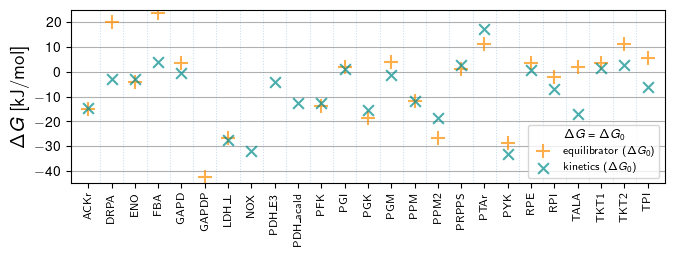

In [21]:
fig_path_deltaG0 = f'{figs_subfoler}/deltaG0_{subsystem}_{simulationDate}'# Indepedent with Q and time period


plot_Gibbs.plot_deltaG0(dG0_equilibrator, dG0_kinetics, 
                       rxns_list, rxn_rev, balance_test, 
                       fig_path_deltaG0)

# excel_path = f'./central_Gibbs_Comparison.xlsx'

# plot_Gibbs.save_Excel(rxns_list, np.round(dG0_equilibrator,2), np.round(dG0_kinetics,2), excel_path)

#### Calculate Gibbs Free Energy Change

In [22]:
# For each reaction in each replicates with ensemble average
Q = np.ones((N_rxn, N_reps+1),dtype=np.double)


for i_rxn in range(N_rxn):
    
    print(rxns_list[i_rxn])
    
    rxn = rxn_model.reactions.get_by_id(rxns_list[i_rxn])
    
    if balance_test[i_rxn] == 0:
        nu_subs, nu_prods, subs, prods = getStoich(rxn)
        
        print("Reaction {0} with substrate {1} and products {2}".format(rxn.id, subs, prods))

        Q[i_rxn,:] = calcQ(pH,conc_df,subs,prods,nu_subs,nu_prods)
        
print(Q)
RTlogQ = RT*np.log(Q)

ACKr
Reaction ACKr with substrate ['actp_c', 'adp_c'] and products ['ac_c', 'atp_c']
DRPA
Reaction DRPA with substrate ['2dr5p_c'] and products ['acald_c', 'g3p_c']
ENO
Reaction ENO with substrate ['2pg_c'] and products ['pep_c']
FBA
Reaction FBA with substrate ['fdp_c'] and products ['dhap_c', 'g3p_c']
GAPD
Reaction GAPD with substrate ['g3p_c', 'nad_c', 'pi_c'] and products ['13dpg_c', 'nadh_c']
GAPDP
Reaction GAPDP with substrate ['g3p_c', 'nadp_c'] and products ['3pg_c', 'nadph_c']
LDH_L
Reaction LDH_L with substrate ['nadh_c', 'pyr_c'] and products ['lac__L_c', 'nad_c']
NOX
PDH_E3
PDH_acald
PFK
Reaction PFK with substrate ['atp_c', 'f6p_c'] and products ['adp_c', 'fdp_c']
PGI
Reaction PGI with substrate ['g6p_c'] and products ['f6p_c']
PGK
Reaction PGK with substrate ['13dpg_c', 'adp_c'] and products ['3pg_c', 'atp_c']
PGM
Reaction PGM with substrate ['3pg_c'] and products ['2pg_c']
PPM
Reaction PPM with substrate ['r1p_c'] and products ['r5p_c']
PPM2
Reaction PPM2 with substrate 

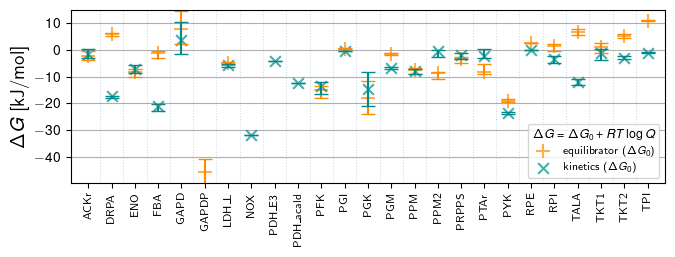

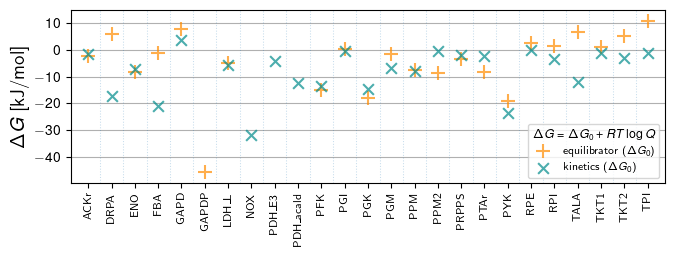

In [23]:
fig_path_deltaG = f'{figs_subfoler}/deltaG_{subsystem}_{simulationDate}_{time_period}'

errorbar = True
fig_path_deltaG_errorbar = fig_path_deltaG + '_' + str(errorbar)

plot_Gibbs.plot_deltaG(dG0_equilibrator, dG0_kinetics, RTlogQ, 
                       rxns_list, rxn_rev, balance_test, 
                       fig_path_deltaG_errorbar, errorbar=errorbar)

errorbar = False
fig_path_deltaG_errorbar = fig_path_deltaG + '_' + str(errorbar)

plot_Gibbs.plot_deltaG(dG0_equilibrator, dG0_kinetics, RTlogQ, 
                       rxns_list, rxn_rev, balance_test, 
                       fig_path_deltaG_errorbar, errorbar=errorbar)

#### Plot Accumulative Gibbs Free Energy

In [24]:
rxn_order_list = ['PGI','PFK','FBA','TPI','GAPD','PGK','PGM','ENO','PYK']
N_order_rxn = len(rxn_order_list)

rxn_order_indices = np.zeros(N_order_rxn,dtype=np.int32)

for i in range(N_order_rxn):
    tmp_rxn = rxn_order_list[i]
    for j in range(N_rxn):
        if rxns_list[j] == tmp_rxn:
            rxn_order_indices[i] = j
            
print(rxn_order_indices)

dG0_order_kinetics = np.zeros(N_order_rxn,dtype=np.double)
dG0_order_equilibrator = np.zeros(N_order_rxn,dtype=np.double)
RTlogQ_order = np.zeros((N_order_rxn, N_reps+1),dtype=np.double)

for i in range(N_order_rxn):
    dG0_order_kinetics[i] = dG0_kinetics[rxn_order_indices[i]]
    dG0_order_equilibrator[i] = dG0_equilibrator[rxn_order_indices[i]]
    RTlogQ_order[i,:] = RTlogQ[rxn_order_indices[i],:]


[11 10  3 24  4 12 13  2 18]


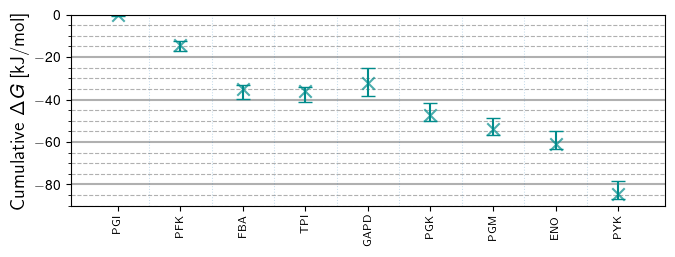

In [25]:
fig_path_accu_deltaG = f'{figs_subfoler}/accum_deltaG_{subsystem}_{simulationDate}_{time_period}'

plot_Gibbs.plot_accumu_deltaG(dG0_order_kinetics, RTlogQ_order, 
                        rxn_order_list, fig_path_accu_deltaG, errorbar=True)

### Export Central, Nucleotide, Lipid Metabolism Gibbs Energy Comparison

25 reactions in Central Metabolism are ACKr, DRPA, ENO, FBA, GAPD, GAPDP, LDH_L, NOX, PDH_E3, PDH_acald, PFK, PGI, PGK, PGM, PPM, PPM2, PRPPS, PTAr, PYK, RPE, RPI, TALA, TKT1, TKT2, TPI
ACKr --- kegg:C00227 + kegg:C00008 = kegg:C00033 + kegg:C00002
dG_equilibrator -15.20 kJ/mol
DRPA --- kegg:C00673 = kegg:C00084 + kegg:C00118
dG_equilibrator 20.28 kJ/mol
ENO --- kegg:C00631 = kegg:C00001 + kegg:C00074
dG_equilibrator -4.06 kJ/mol
FBA --- kegg:C00354 = kegg:C00111 + kegg:C00118
dG_equilibrator 23.80 kJ/mol
GAPD --- kegg:C00118 + kegg:C00003 + kegg:C00009 = kegg:C00236 + kegg:C00080 + kegg:C00004
dG_equilibrator 3.67 kJ/mol
GAPDP with 0 k_reverse
GAPDP --- kegg:C00118 + kegg:C00001 + kegg:C00006 = kegg:C00197 + kegg:C00080 + kegg:C00080 + kegg:C00005
dG_equilibrator -42.53 kJ/mol
LDH_L --- kegg:C00080 + kegg:C00004 + kegg:C00022 = kegg:C00186 + kegg:C00003
dG_equilibrator -26.60 kJ/mol
NOX --- kegg:C00080 + kegg:C00080 + kegg:C00004 + kegg:C00004 + kegg:C00007 = kegg:C00001 + kegg:C00001

/home/enguang/anaconda3/envs/eQuilibrator/lib/python3.12/site-packages/equilibrator_cache/reaction.py:606: UserWarning: Cannot calculate Legendre transform for Compound(id=116458, inchi_key=None): Compound(id=116458, inchi_key=None) has not yet been analyzed by ChemAxon.
  warnings.warn(
/home/enguang/anaconda3/envs/eQuilibrator/lib/python3.12/site-packages/equilibrator_cache/reaction.py:606: UserWarning: Cannot calculate Legendre transform for Compound(id=850, inchi_key=None): Compound(id=850, inchi_key=None) has not yet been analyzed by ChemAxon.
  warnings.warn(
/home/enguang/anaconda3/envs/eQuilibrator/lib/python3.12/site-packages/equilibrator_cache/reaction.py:606: UserWarning: Cannot calculate Legendre transform for Compound(id=858, inchi_key=None): Compound(id=858, inchi_key=None) has not yet been analyzed by ChemAxon.
  warnings.warn(
/home/enguang/anaconda3/envs/eQuilibrator/lib/python3.12/site-packages/equilibrator_cache/reaction.py:606: UserWarning: Cannot calculate Legendre

dG_equilibrator -13.02 kJ/mol
PAPA --- kegg:C00001 + kegg:C00416 = kegg:C00641 + kegg:C00009
The reaction is not balanced judged from eQuialibrator. PAPA
PGMT --- kegg:C00092 = kegg:C00103
dG_equilibrator 7.42 kJ/mol
PGPP with 0 k_reverse
PGPP --- kegg:C00001 + kegg:C03892 = kegg:C00344 + kegg:C00009
The reaction is not balanced judged from eQuialibrator. PGPP
PGSA with 0 k_reverse
PGSA --- kegg:C00269 + kegg:C00093 = kegg:C00055 + kegg:C00080 + kegg:C03892
The reaction is not balanced judged from eQuialibrator. PGSA
UDPG4E --- kegg:C00029 = kegg:C00052
dG_equilibrator 2.92 kJ/mol
UDPGALM --- kegg:C00052 = kegg:C03733
dG_equilibrator 1.07 kJ/mol
Number unbalanced = 10
Reaction ACPPAT with substrate ['ACP_c', 'ap_c'] and products ['ACP_R_c', 'pi_c']
Reaction Quotient is 1.01e+03 and contributed 17.43 kJ/mol to dG
Reaction ACPS with substrate ['apoACP_c', 'coa_c'] and products ['ACP_c', 'pap_c']
Reaction Quotient is 3.01e+00 and contributed 2.77 kJ/mol to dG
Reaction AGPAT with substrate

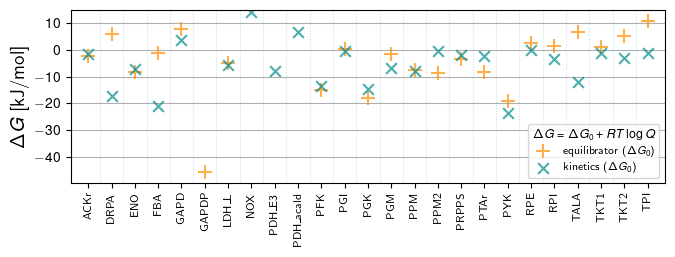

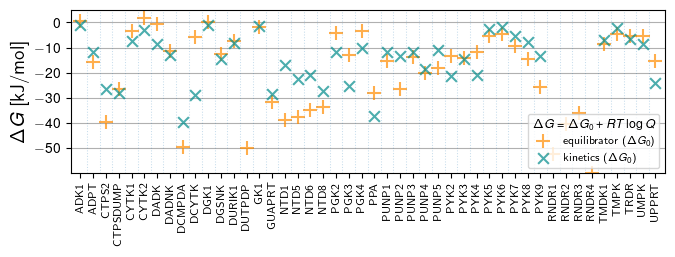

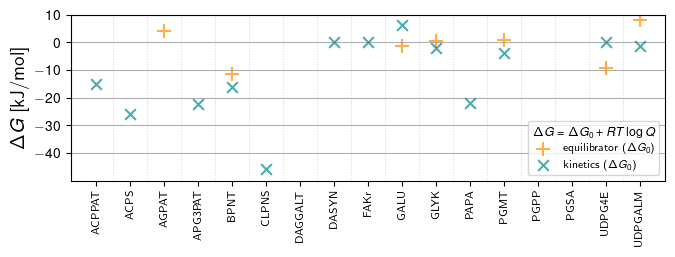

In [26]:
subsystems = ['Central', 'Nucleotide', 'Lipid']
# subsystems = ['Lipid']

excel_path = f'./{simulationDate}/Gibbs_Comparison.xlsx'

dG_lim = 200

dfs = []

for subsystem in subsystems:

    subsystem_params_df = pd.read_excel(kinetic_params_path, sheet_name=subsystem)

    rxns_list = list(set(subsystem_params_df['Reaction Name']))

    rxns_list.sort() # Order by a,b,c ...
    
    N_rxn = len(rxns_list)

    print('{0} reactions in {1} Metabolism are {2}'.format(
                                        N_rxn, subsystem, ', '.join(rxns_list)))

    met_df = pd.read_excel(initial_concentrations_path, sheet_name='Intracellular Metabolites',header=0)

    kcat_forward = -np.ones((N_rxn),dtype=np.double)
    kcat_reverse = -np.ones((N_rxn),dtype=np.double)
    keq = -np.ones((N_rxn),dtype=np.double)
    FBA_rev = {}

    # Get the k_f and k_r for each reaction
    for i_rxn in range(N_rxn):
        rxn_df = subsystem_params_df.loc[subsystem_params_df['Reaction Name']==rxns_list[i_rxn]]
        kcat_forward[i_rxn] = rxn_df.loc[
            rxn_df['Parameter Type']=='Substrate Catalytic Rate Constant'
                                        ,'Value'].iloc[0]
        kcat_reverse[i_rxn] = rxn_df.loc[
            rxn_df['Parameter Type']=='Product Catalytic Rate Constant'
                                        ,'Value'].iloc[0]

    rxn_rev = np.where(kcat_reverse > 1.0E-5, 1, 0).astype(np.int32)

    SBML_path = '/data/enguang/CMEODE/input_data/Syn3A_updated.xml'
    rxn_model = cobra.io.read_sbml_model(SBML_path)

    keq_equilibrator = np.zeros((N_rxn),dtype=np.double)
    balance_test = np.zeros((N_rxn),dtype=np.int32)

    for i_rxn in range(N_rxn):
        
        rxn = rxn_model.reactions.get_by_id(rxns_list[i_rxn])
        
        # Get kinetic K_eq
        kcat_forward[i_rxn], kcat_reverse[i_rxn], keq[i_rxn], FBA_rev[rxns_list[i_rxn]] = getKcatsKeq(subsystem_params_df,rxn)
        
        rxn_str = parse_MetRXN_KEGG(met_df,rxn)
        
        print(rxns_list[i_rxn] + ' --- ' + rxn_str)
        
        tmp_rxn = cc.parse_reaction_formula(rxn_str)

        if tmp_rxn.is_balanced() == False: # function in eQuialibrator to check the material balance of reactions
            
            print('The reaction is not balanced judged from eQuialibrator. ' + rxns_list[i_rxn])
            keq_equilibrator[i_rxn] = np.nan
            balance_test[i_rxn] = 1

        else:
            # get reaction thermodynamic standard gibbs free energy
            dG_prime = cc.dg_prime(tmp_rxn)
            if np.abs(dG_prime.value.m_as("kJ/mol")) > dG_lim:
                keq_equilibrator[i_rxn] = np.nan
            else:
                keq_equilibrator[i_rxn] = dG_prime.value.m_as("kJ/mol")

            print(f'dG_equilibrator {keq_equilibrator[i_rxn]:.2f} kJ/mol')
            
        
    print('Number unbalanced = '+str(np.sum(balance_test)))


    # standard Gibbs free energy from thermodynamic
    dG0_equilibrator = np.copy(keq_equilibrator)

    # Standard Gibbs free energy from kinetic
    dG0_kinetics = -RT*np.log(keq)

    remove_indices = np.argwhere(np.abs(keq_equilibrator)>dG_lim)
    balance_test[remove_indices] = 1
    
    # print(keq_equilibrator)
    Q = np.ones((N_rxn, N_reps+1),dtype=np.double)

    # Calculate Reaction Quotient
    for i_rxn in range(N_rxn):
    
        # print(rxns_list[i_rxn])
        
        rxn = rxn_model.reactions.get_by_id(rxns_list[i_rxn])
        
        # if balance_test[i_rxn] == 0: 
        nu_subs, nu_prods, subs, prods = getStoich(rxn)
        
        print("Reaction {0} with substrate {1} and products {2}".format(rxn.id, subs, prods))

        Q_rxn = calcQ(pH,conc_df,subs,prods,nu_subs,nu_prods)
        Q[i_rxn,:] = Q_rxn
        
        print(f"Reaction Quotient is {Q_rxn[0]:.2e} and contributed {RT*np.log(Q_rxn[0]):.2f} kJ/mol to dG")


    RTlogQ = RT*np.log(Q)

    dG_equilibrator = dG0_equilibrator + RTlogQ[:,0]

    dG_kinetics = dG0_kinetics + RTlogQ[:,0]

    df = plot_Gibbs.return_df(rxns_list, 
                               np.round(dG0_equilibrator, 2), 
                               np.round(dG0_kinetics, 2), 
                               np.round(dG_equilibrator, 2),
                               np.round(dG_kinetics, 2),
                               np.round(RTlogQ[:,0],2))

    dfs.append(df)

    fig_path_deltaG = f'{figs_subfoler}/deltaG_{subsystem}_{simulationDate}_{time_period}'

    errorbar = False
    fig_path_deltaG_errorbar = fig_path_deltaG + '_' + str(errorbar)

    plot_Gibbs.plot_deltaG(dG0_equilibrator, dG0_kinetics, RTlogQ, 
                        rxns_list, rxn_rev, balance_test, 
                        fig_path_deltaG_errorbar, errorbar=errorbar)




with pd.ExcelWriter(excel_path) as writer:
    for subsystem, df in zip(subsystems, dfs):
        df.to_excel(writer, sheet_name=subsystem, index=False)



### Flux Plot